### [Tbrain Yushan House Price Project](https://tbrain.trendmicro.com.tw/Competitions/Details/6)
- Purpose: To predict the house price in Taiwan using Machine Learning
- Evaluation: round(Hit Rate,4)*10^4 + (1-(1-MAPE if MAPE>1 else MAPE))
    * Hit Rate = sum(z)/n -> z = 1 if abs((y_hat-y)/y)<=0.1 else z=0
    * MAPE = sum(abs((y_hat-y)/y))/n    
- Summary:
    * 60K train data and 10K test data
    * unit_price might be more accurate than total_price
    * one data from city 7 might label wrong -> this may be city 10 instead of city 7
    * some town with wrong label

In [2]:
#--- import some necessary librairies

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from scipy.special import boxcox1p,inv_boxcox1p
from scipy.stats import boxcox_normmax,boxcox

from subprocess import check_output
from sklearn.externals import joblib

In [5]:
train = pd.read_csv('/Users/chloe/Documents/GitHub/Kaggle_Competition/TBrain/Yushan/Dataset/train.csv')
test = pd.read_csv('/Users/chloe/Documents/GitHub/Kaggle_Competition/TBrain/Yushan/Dataset/test.csv')

In [7]:
#--- check the size of the data and drop building_id
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

train_ID = train['building_id']
test_ID = test['building_id']

train.drop("building_id", axis = 1, inplace = True)
test.drop("building_id", axis = 1, inplace = True)

print("The train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (60000, 235) 
The test data size before dropping Id feature is : (10000, 234) 
The train data size after dropping Id feature is : (60000, 234) 
The test data size after dropping Id feature is : (10000, 233) 


### 4 features with missing value - parking_area, parking_price, txn_floor, village_income_median
- parking_area: >90% is missing value
- txn_floor: data with na bc the building_type = 4

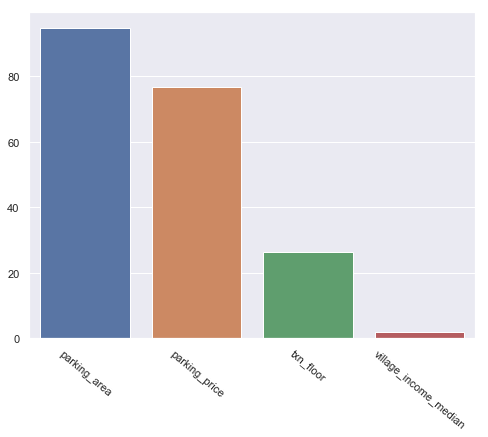

In [70]:
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(8, 6))
plt.xticks(rotation='-40')
sns.barplot(x=train_na.index, y=train_na)
plt.show()

In [73]:
# building_type=4 -> txn_floor will be all missing value -> they buy whole building (single-family house)
train[pd.isnull(train["txn_floor"])]["building_type"].unique()

array([4])

### Mapping city with longtitude and latitude data
- image need to rotate -45 degree to map to taiwan map
- unit price for city 7 & 13 are the highest -> 7: new taipei city; 13: taipei city

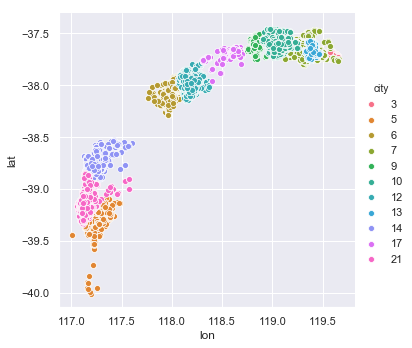

In [54]:
# should rotate 45 degree to make it map to tw 
sns.set(rc={'figure.figsize':(6,8)})
image1 = sns.pairplot(x_vars=["lon"], y_vars=["lat"], data=train, hue="city", size=5)
image1.savefig("tw_map.png")

rotate -45 degree will can map back to actual correspond city
<img src = 'tw_map_rotate.png'>

In [53]:
train.groupby("city")["total_price"].describe()

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
3,813.000,3055048.123,4444050.181,301261.351,1108523.817,1648820.755,2990101.942,44299569.804
5,1224.000,3348418.019,11799006.059,237864.558,762137.425,1235981.029,2636756.296,224670236.661
6,826.000,5685889.689,12896783.269,339560.351,1562557.941,2585254.628,5152761.111,246843973.780
7,19664.000,11412136.654,42816651.643,353184.256,4020198.200,6521007.320,10673092.683,2169518926.876
9,1125.000,11058631.464,33256173.814,396452.000,2432527.357,4892755.726,10195802.052,630700218.840
10,4676.000,6428258.559,13780723.910,262963.582,1796452.000,3321452.000,6145399.734,367619913.417
12,7264.000,8723268.473,25856833.513,226149.524,2299728.968,4120925.631,7996185.909,1423614872.564
13,10756.000,32824380.426,106361157.562,563875.461,8510295.876,15469958.474,30626127.421,5088279096.769
14,4704.000,5913153.647,19244451.556,237864.558,1467341.289,2727088.339,5216255.255,631316159.971


In [120]:
#train.groupby(["unit_price"]).size().sort_values(ascending=False)

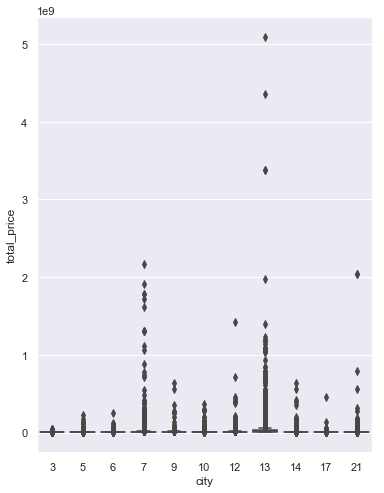

In [84]:
sns.boxplot(x=train["city"], y=train["total_price"])

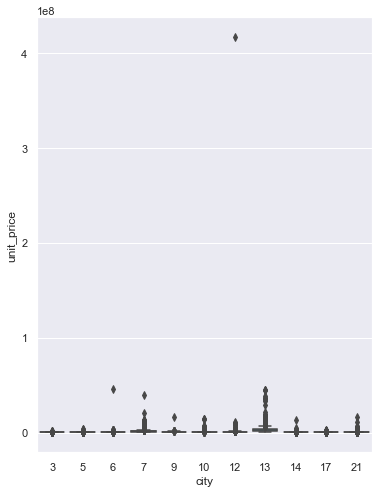

In [85]:
sns.boxplot(x=train["city"], y=train["unit_price"])

In [90]:
# one data for city 7 might label wrong
train.groupby(["city", 'doc_Rate', 'master_rate', 'bachelor_rate']).size()

city  doc_Rate  master_rate  bachelor_rate
3     0.002     0.036        0.182              813
5     0.002     0.028        0.155             1224
6     0.002     0.034        0.176              826
7     0.003     0.048        0.214                1
      0.004     0.049        0.216            19663
9     0.006     0.069        0.222             1125
10    0.003     0.048        0.214             4676
12    0.004     0.050        0.218             7264
13    0.011     0.099        0.303            10756
14    0.004     0.048        0.212             4704
17    0.002     0.036        0.180              984
21    0.004     0.048        0.208             7964
dtype: int64

In [98]:
train[(train["city"]==7)&(round(train["doc_Rate"],3)!=0.004)].index

Int64Index([6508], dtype='int64')

In [112]:
# some towns are wrong
town = train.groupby(['town', 'town_area', 'town_population_density']).size().reset_index()
#town.to_csv("wrong_town.csv", index=False)

### building_type information ([Ref from Taiwanee Gov.](http://www.housing.taipei.gov.tw/h_statistics-4-3.aspx))
- 0: apartments -> (住宅大樓) 
- 1: apartments -> (公寓)
- 2: apartments -> suit (套房)
- 3: apartments -> with max total floors <=11 (華廈) 
- 4: single-family house (透天)
---
* 「公寓」多數都是屋齡偏高，並且沒有「電梯、停車位」的住宅
* 「華廈」多數指的是五～七樓以下，同時配有電梯、停車位的社區住宅
* 「大樓」一般泛指七樓以上含電梯的社區住宅，屋齡較新，約在10年以內，而現在的預售屋，也都是採大樓形式建造，與「華廈」一樣配有電梯、停車位

In [42]:
train["building_type"].sort_values().unique()

array([0, 1, 2, 3, 4])

In [35]:
train.groupby(["building_type"])["total_floor"].agg(["min", "max", "mean"])

,min,max,mean
building_type,,,
0,11,29,14.637
1,1,22,4.595
2,2,28,11.172
3,2,10,7.441
4,1,5,3.116


In [45]:
# identify 4 is single family house -> txn_floor all nan
train[train["building_type"]==4]["txn_floor"].unique()

array([nan])

In [44]:
# to differentiate 0,1,2 -> check the building_area -> find out 2 is suit
train.groupby(["building_type"])["building_area"].agg(["min", "max", "mean"])

,min,max,mean
building_type,,,
0,0.623,639.175,11.202
1,0.491,566.506,5.617
2,0.366,216.456,2.420
3,0.763,693.751,9.192
4,1.217,3730.983,15.538


In [52]:
train.groupby(['building_type'])["total_price"].agg(["min","max","mean"])

,min,max,mean
building_type,,,
0,247048.443,1973376626.237,17333203.731
1,229974.807,1226497801.587,8625902.890
2,226149.524,117328900.894,3798923.563
3,237864.558,4357039345.656,14178890.312
4,247068.176,5088279096.769,13478831.948


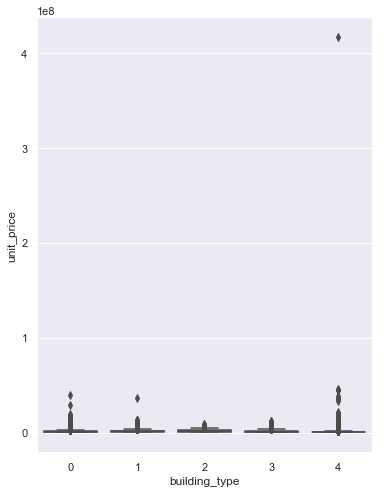

In [122]:
sns.boxplot(x=train["building_type"], y=train["unit_price"]);

### Compare total_price & unit_price

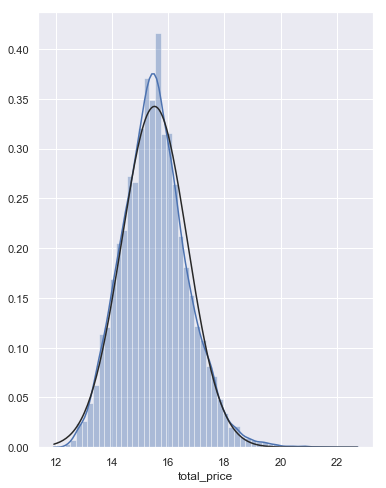

In [124]:
sns.distplot(np.log1p(train["total_price"]), fit=norm);

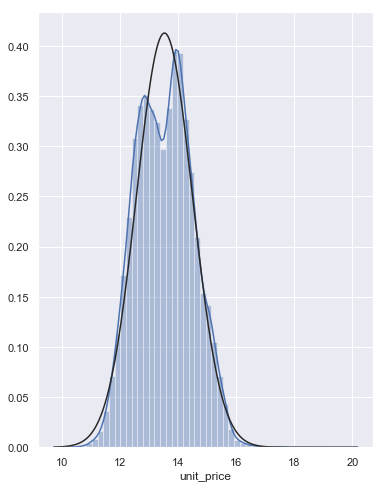

In [125]:
train["unit_price"] = train["total_price"]/train["building_area"]
sns.distplot(np.log1p(train["unit_price"]), fit=norm);

In [126]:
# use qq plot to analyse two follow the same distribution